# Experimentos

importamos las librerías necesarias para estos experimentos

In [1]:
import numpy as np
from scipy import stats
import pickle
import pandas as pd
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors

## Funciones para leer imagenes, cargar voxeles de la imagen, etc.

In [2]:
def read_kImage(path):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(path)
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    return ct_scan

In [3]:
def extract_voxel_data(series_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames( series_path )
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    image_3d = sitk.GetArrayFromImage(image)
    return image_3d

In [4]:
def extract_slice_data(img_3d, ijk):
    state = False
    k_string = ijk.split()[2]
    max_bandwith = img_3d.shape[0]
    possible_k = int (k_string)
    if (possible_k >= max_bandwith):
        possible_k = max_bandwith -1
        slice_index = possible_k
        state = True
        print("The ijk requested is {}, there was an error since the shapes of the image is {}".format(ijk,str(img_3d.shape)))
    else:
        slice_index = possible_k
        print("The ijk requested is {},OK since shapes of the image is {}".format(ijk,str(img_3d.shape)))
    return state, img_3d[slice_index,:,:]

# Funciones para crear subvoxeles 

## slices n-1, n y n+1 con 40x40 cada uno

### Subvoxel (3,40,40)

In [5]:
def subvoxel (img_3d,ijk, window):
    new_img3d = np.empty(shape = (3,img_3d.shape[1], img_3d.shape[2]))
    ijk = ijk.split()
    max_bandwith = img_3d.shape[0]
    if (int(ijk[2]) == max_bandwith):
        new_img3d[0,:,:] = img_3d[int(ijk[2])-1,:,:] #n-1
        new_img3d[1,:,:] = img_3d[int(ijk[2]),:,:] #n
        new_img3d[2,:,:] = img_3d[int(ijk[2]),:,:] #n
    else:
        if (int(ijk[2]) == 0):
            new_img3d[0,:,:] = img_3d[int(ijk[2]),:,:] #0
            new_img3d[1,:,:] = img_3d[int(ijk[2]),:,:] #0
            new_img3d[2,:,:] = img_3d[int(ijk[2])+1,:,:] #1
        else:
            new_img3d[0,:,:] = img_3d[int(ijk[2])-1,:,:] #n-1
            new_img3d[1,:,:] = img_3d[int(ijk[2]),:,:] #n
            new_img3d[2,:,:] = img_3d[int(ijk[2])+1,:,:] #n+1
    window = window//2
    new_img3d = new_img3d[:, int(ijk[0])-window : int(ijk[0])+window, int(ijk[1])-window : int(ijk[1])+window]
    return new_img3d

## Funciones para generar tablas, editar tablas, operaciones entre tablas, etc.

In [6]:
def generate_training_tables():
    basedir = "../1/train/ProstateX-TrainingLesionInformationv2/ProstateX-TrainingLesionInformationv2"
    findingsfile = "{}/{}".format(basedir,"ProstateX-Findings-Train.csv")
    imagesfile = "{}/{}".format(basedir,"ProstateX-Images-Train.csv")
    kimagesfile = "{}/{}".format(basedir,"ProstateX-Images-KTrans-Train.csv")
    #Generamos las 3 tablas básicas a partir de los archivos.cvs
    findings_table = pd.read_csv(findingsfile)
    images_table = pd.read_csv(imagesfile)
    kimages_table = pd.read_csv(kimagesfile)
    #Operación de inner join entre tablas.
    join_kimages_table = pd.merge(left=findings_table, right= kimages_table, how ="inner", on=["ProxID","fid","pos"])
    join_images_table =  pd.merge(left=findings_table, right=  images_table, how ="inner", on=["ProxID","fid","pos"])
    #agregamos una columna para insertar la imagen
    join_images_table["MRI"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["MRI3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["State"] = pd.Series(False, index= join_images_table.index)
    join_kimages_table["Kimg"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["Kimg3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["KimgPatch3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["State"] = pd.Series(False, index= join_kimages_table.index)
    return join_images_table, join_kimages_table

In [7]:
def set_MRI_value(index,image2d,image3d,state):
    join_images_table.at[index,"MRI"] = image2d
    join_images_table.at[index,"MRI3D"] = image3d
    join_images_table.at[index,"State"] = state

In [8]:
def set_kImg_value(index,image2d,image3d,state):
    window = 40
    row = join_kimages_table.iloc[index]
    join_kimages_table.at[index,"Kimg"] = image2d
    join_kimages_table.at[index,"Kimg3D"] = image3d
    join_kimages_table.at[index,"State"] = state
    if state == False:
        join_kimages_table.at[index,"KimgPatch3D"] = subvoxel(img_3d=image3d, ijk=row.ijk, window=window)
    else:
        join_kimages_table.at[index,"KimgPatch3D"] = np.empty(shape= image3d.shape)
    

In [9]:
def insert_k_images():
    for row in range(len(join_kimages_table)):
        path = "../1/Train/ProstateXKtrains-train-fixed"
        patient_id = join_kimages_table.ProxID.iloc[row]
        ijk = join_kimages_table.ijk.iloc[row]
        path = "{}/{}".format(path,patient_id)
        path = "{}/{}-Ktrans.mhd".format(path,patient_id)
        kimage_3d = read_kImage(path)
        state, kimage_2d = extract_slice_data(kimage_3d,ijk)
        set_kImg_value(row,kimage_2d,kimage_3d,state)
        print("Se ha cargado la Kimagen2d y la kimagen3d #{} para el paciente {} ".format(row,patient_id))
        del path,patient_id,kimage_3d,state


In [10]:
def insert_MRI_images():
    for row in range (len(join_images_table)):
        patient_id = join_images_table.ProxID.iloc[row]
        series_name = join_images_table.DCMSerDescr.iloc[row]
        series_id = join_images_table.DCMSerNum.iloc[row]
        slice_ijk = join_images_table.ijk.iloc[row]
        path = "../1/Train/PROSTATEx/{}/".format(patient_id)#Selects the Patient ID
        path = "{}/{}".format(path,os.listdir(path)[0])#Selects the default folder inside the patient
        sequences = os.listdir(path) # Selects all the sequences
        sequence = [ sequence for sequence in sequences if sequence[0:len(str(series_id))] == str(series_id) ] [0]
        # Selects the only sequence that matches the condition.
        path = "{}/{}".format(path,sequence)
        image_3d = extract_voxel_data(path)
        state, image_2d = extract_slice_data(image_3d,slice_ijk)
        set_MRI_value(row,image_2d,image_3d,state)
        print("Se ha cargado la imagen MRI2D y MRI3D #{} para el paciente {} serie: {} ".format(row,patient_id,series_name))
        del path, patient_id, series_name, series_id,sequence,sequences, image_3d, image_2d

## Funciones para verificar la integridad de los datos.

In [11]:
def checkout_Kimgs_problems():
    k_problems_table = join_kimages_table[join_kimages_table["State"] == True] 
    print("There were {} problems".format(len(k_problems_table)))
    percent = 100*float(len(k_problems_table)/len(join_kimages_table))

    print("It was the  {0:.5f}% of the dataset".format(percent))
    display(k_problems_table[["ProxID","ijk","State", "zone"]])

In [12]:
def checkout_MRI_table_problems():
    MRI_problems_table = join_images_table[join_images_table["State"] == True] 
    print("There were {} problems".format(len(MRI_problems_table)))
    percent = 100*float(len(MRI_problems_table)/len(join_images_table))
    print("It was the  {0:.5f}% of the dataset".format(percent))
    display(MRI_problems_table[["ProxID","fid","ClinSig","State","Name","DCMSerDescr"]])
    
    patient_problems = MRI_problems_table.ProxID.unique()
    print("The following patients have almost 1 currupted image. {}".format(patient_problems))
    candidate_table = join_images_table
    for patient in patient_problems:
        candidate_table = candidate_table[candidate_table["ProxID"] != patient]
    print("This would be the table with none of the patients with atleast 1 problem.")
    display(candidate_table[["ProxID","fid","ClinSig","State","Name","DCMSerDescr"]])
    del MRI_problems_table, percent,  patient_problems, candidate_table, patient


## Funciones para generar un Dataframe de entrenamiento, datos de entrenamiento y labels de entrenamiento

In [13]:
def get_training_testing_tables(zone):
    #Base table with correct data and the zone requested.
    
    base_table = join_kimages_table[(join_kimages_table["State"] == False) & (join_kimages_table["zone"] == zone)]
    #Indexing zone for cancer and non-cancer rows.
    
    cancer_table_indexes = base_table[base_table["ClinSig"] == True].index.values
    non_cancer_table_indexes = base_table[base_table["ClinSig"] == False].index.values
    #Number of Samples for training and testing for cancer and non-cancer classes.
    
    training_cancer_samples = len(cancer_table_indexes)//2
    testing_cancer_samples = len(cancer_table_indexes) - training_cancer_samples
    training_non_cancer_samples = (len(non_cancer_table_indexes)//2)
    testing_non_cancer_samples = len(non_cancer_table_indexes) - training_non_cancer_samples
    #Training and testing table for cancer class
    
    training_cancer_table = join_kimages_table.iloc[cancer_table_indexes[:training_cancer_samples]]
    testing_cancer_table = join_kimages_table.iloc[cancer_table_indexes[training_cancer_samples:]]
    #Training and testing table for non-cancer class
    
    training_non_cancer_table = join_kimages_table.iloc[non_cancer_table_indexes[:training_non_cancer_samples]]
    testing_non_cancer_table = join_kimages_table.iloc[non_cancer_table_indexes[training_non_cancer_samples:]]
    #Integrity of the data

    #Joins training table and testing table.
    training_table = training_cancer_table.append(training_non_cancer_table)
    testing_table = testing_cancer_table.append(testing_non_cancer_table)
    training_table = training_table.sample(frac=1).reset_index(drop=True)
    testing_table = testing_table.sample(frac=1).reset_index(drop=True)

    return training_table,testing_table

In [14]:
def get_data_labels_Kimages(table):
    rows,cols = table.Kimg.iloc[0].shape
    data = np.ndarray(shape=(len(table), rows, cols),
                             dtype=np.float32)
    labels = np.ndarray(shape=(len(table),1),
                             dtype=np.float32)
    for index in range (len(table)):
        curr_rows,curr_cols = table.Kimg.iloc[index].shape
        if((curr_rows != rows or curr_cols != cols)):
            data[index, : , : ] = table.Kimg.iloc[index][:rows,:cols]
            labels[index] = table.ClinSig.iloc[index]
        else:
            data[index, : , : ] = table.Kimg.iloc[index]
            labels[index] = table.ClinSig.iloc[index]
    print("The shape of the data is: {}".format(data.shape) )
    data  = data.reshape((len(table),rows*cols))
    print("The shape of the data was reshaped to: {}".format(data.shape))
    labels = labels.reshape((len(table),))
    del table
    return data, labels

## Funciones para métricas estadísticas de los datos.

In [15]:
def get_TPR_TNR(testing_labels, predicted_labels):
    #Calculates the true positive rate and the true negative rate
    TP = 0
    TN = 0
    P = sum(testing_labels == True)
    N = sum(testing_labels == False)
    for i in range(len(testing_labels)):
        if (predicted_labels[i] == testing_labels[i]):
            if(testing_labels[i] == False):
                TN = TN + 1
            else:
                TP = TP + 1           
    TPR = TP/P
    TNR = TN/N
    return TPR, TNR , P , N

## Flujo principal de los Experimentos

In [16]:
join_images_table, join_kimages_table =  generate_training_tables()


In [ ]:
insert_k_images()


In [18]:
print("==============================================================================================")
checkout_Kimgs_problems()

There were 3 problems
It was the  0.89552% of the dataset


,ProxID,ijk,State,zone
34,ProstateX-0025,89 67 24,True,PZ
159,ProstateX-0105,63 78 17,True,SV
248,ProstateX-0154,57 72 16,True,SV


In [ ]:
insert_MRI_images()
print("==============================================================================================")
checkout_MRI_table_problems()

In [19]:
classifiers_table = pd.DataFrame(columns=["Classifier name","Prostate zone","Samples","Score", "TPR" , "P", "TNR", "N"])
zones = join_kimages_table[join_kimages_table["State"] == False].zone.unique()
for zone in zones:
    print("this is an experiment for the zone: {}".format(zone))
    training_table, testing_table = get_training_testing_tables(zone)
    print ("There is a total of {} patients with cancer at the training data".format(sum(training_table.ClinSig)))
    print ("There is a total of {} patients with cancer at the testing data".format(sum (testing_table.ClinSig)))
    training_data, training_labels = get_data_labels_Kimages(training_table)
    testing_data, testing_labels = get_data_labels_Kimages(testing_table)
    print("The data and the labels are ready for training and testing.") 
    print("=====================================================================================================")
    classifier1 = GaussianNB()
    classifier1.fit(training_data, training_labels)
    result = classifier1.score(testing_data,testing_labels)
    #Calculates the true positive rate and the true negative rate
    predicted_labels = classifier1.predict(testing_data)
    TPR, TNR , P , N = get_TPR_TNR(testing_labels, predicted_labels)
    print ("This was an experiment using GaussianNB classifier and only kimages of the {}.".format(zone)) 
    print("the number of samples in training were {} ".format(
    len(training_table)) + "and the number of samples in testing were {} ".format(len(testing_data)))
    print("the score of the accuracy in this experiment was {0:.5f}%".format(float(result)*100))
    print("This means that there was {}/{} correct predictions at testing.".format(int(result*len(testing_data)), len(testing_data) ))
    index = len(classifiers_table)
    classifiers_table.at[index,"Classifier name"] = "GaussianNB"
    classifiers_table.at[index,"Prostate zone"] = zone
    classifiers_table.at[index,"Score"] = result
    classifiers_table.at[index,"Samples"] = "{}/{}".format(int(result*len(testing_data)), len(testing_data) )
    classifiers_table.at[index,"TPR"] = TPR
    classifiers_table.at[index,"TNR"] = TNR
    classifiers_table.at[index,"P"] = P
    classifiers_table.at[index,"N"] = N
    print("=====================================================================================================")
    classifier2 = svm.SVC()
    classifier2.fit(training_data, training_labels)
    result = classifier2.score(testing_data,testing_labels)
    #Calculates the true positive rate and the true negative rate
    predicted_labels = classifier2.predict(testing_data)
    TPR, TNR , P , N = get_TPR_TNR(testing_labels, predicted_labels)
    print("=====================================================================================================")
    print ("This was an experiment using SVM-SVC classifier and only kimages of the {}.".format(zone)) 
    print("the number of samples in training were {} ".format(
    len(training_table)) + "and the number of samples in testing were {} ".format(len(testing_data)))
    print("the score of the accuracy in this experiment was {0:.5f}%".format(float(result)*100))
    print("This means that there was {}/{} correct predictions at testing.".format(int(result*len(testing_data)), len(testing_data) ))
    index = len(classifiers_table)
    classifiers_table.at[index,"Classifier name"] = "SVM-SVC"
    classifiers_table.at[index,"Prostate zone"] = zone
    classifiers_table.at[index,"Score"] = result
    classifiers_table.at[index,"Samples"] = "{}/{}".format(int(result*len(testing_data)), len(testing_data) )
    classifiers_table.at[index,"TPR"] = TPR
    classifiers_table.at[index,"TNR"] = TNR
    classifiers_table.at[index,"P"] = P
    classifiers_table.at[index,"N"] = N
    print("=====================================================================================================")
    print("=====================================================================================================")
    classifier3 = tree.DecisionTreeClassifier()
    classifier3.fit(training_data, training_labels)
    result = classifier3.score(testing_data,testing_labels)
    #Calculates the true positive rate and the true negative rate
    predicted_labels = classifier3.predict(testing_data)
    TPR, TNR , P , N = get_TPR_TNR(testing_labels, predicted_labels)
    print ("This was an experiment using Decision Tree classifier and only kimages of the {}.".format(zone)) 
    print("the number of samples in training were {} ".format(
    len(training_table)) + "and the number of samples in testing were {} ".format(len(testing_data)))
    print("the score of the accuracy in this experiment was {0:.5f}%".format(float(result)*100))
    print("This means that there was {}/{} correct predictions at testing.".format(int(result*len(testing_data)), len(testing_data) ))
    index = len(classifiers_table)
    classifiers_table.at[index,"Classifier name"] = "Decision Tree"
    classifiers_table.at[index,"Prostate zone"] = zone
    classifiers_table.at[index,"Score"] = result
    classifiers_table.at[index,"Samples"] = "{}/{}".format(int(result*len(testing_data)), len(testing_data) )
    classifiers_table.at[index,"TPR"] = TPR
    classifiers_table.at[index,"TNR"] = TNR
    classifiers_table.at[index,"P"] = P
    classifiers_table.at[index,"N"] = N
    print("=====================================================================================================")
    print("=====================================================================================================")
    n_estimators = 20
    classifier4 = RandomForestClassifier(n_estimators=n_estimators)
    classifier4.fit(training_data, training_labels)
    result = classifier4.score(testing_data,testing_labels)
    #Calculates the true positive rate and the true negative rate
    predicted_labels = classifier4.predict(testing_data)
    TPR, TNR , P , N = get_TPR_TNR(testing_labels, predicted_labels)
    print ("This was an experiment using Random Forest classifier and only kimages of the {}.".format(zone)) 
    print("the number of samples in training were {} ".format(
    len(training_table)) + "and the number of samples in testing were {} ".format(len(testing_data)))
    print("the score of the accuracy in this experiment was {0:.5f}%".format(float(result)*100))
    print("This means that there was {}/{} correct predictions at testing.".format(int(result*len(testing_data)), len(testing_data) ))
    index = len(classifiers_table)
    classifiers_table.at[index,"Classifier name"] = "Random Forest-{}".format(n_estimators)
    classifiers_table.at[index,"Prostate zone"] = zone
    classifiers_table.at[index,"Score"] = result
    classifiers_table.at[index,"Samples"] = "{}/{}".format(int(result*len(testing_data)), len(testing_data) )
    classifiers_table.at[index,"TPR"] = TPR
    classifiers_table.at[index,"TNR"] = TNR
    classifiers_table.at[index,"P"] = P
    classifiers_table.at[index,"N"] = N
    print("=====================================================================================================")
    print("=====================================================================================================")
    n_neighbors=20
    classifier5 = neighbors.KNeighborsClassifier(n_neighbors)
    classifier5.fit(training_data, training_labels)
    result = classifier5.score(testing_data,testing_labels)
    #Calculates the true positive rate and the true negative rate
    predicted_labels = classifier5.predict(testing_data)
    TPR, TNR , P , N = get_TPR_TNR(testing_labels, predicted_labels)
    print ("This was an experiment using KNeighbors classifier and only kimages of the {}.".format(zone)) 
    print("the number of samples in training were {} ".format(
    len(training_table)) + "and the number of samples in testing were {} ".format(len(testing_data)))
    print("the score of the accuracy in this experiment was {0:.5f}%".format(float(result)*100))
    print("This means that there was {}/{} correct predictions at testing.".format(int(result*len(testing_data)), len(testing_data) ))
    index = len(classifiers_table)
    classifiers_table.at[index,"Classifier name"] = "KNeighbors-{}".format(n_neighbors)
    classifiers_table.at[index,"Prostate zone"] = zone
    classifiers_table.at[index,"Score"] = result
    classifiers_table.at[index,"Samples"] = "{}/{}".format(int(result*len(testing_data)), len(testing_data) )
    classifiers_table.at[index,"TPR"] = TPR
    classifiers_table.at[index,"TNR"] = TNR
    classifiers_table.at[index,"P"] = P
    classifiers_table.at[index,"N"] = N
    print("=====================================================================================================")


this is an experiment for the zone: PZ
There is a total of 18 patients with cancer at the training data
There is a total of 18 patients with cancer at the testing data
The shape of the data is: (97, 128, 128)
The shape of the data was reshaped to: (97, 16384)
The shape of the data is: (97, 128, 128)
The shape of the data was reshaped to: (97, 16384)
The data and the labels are ready for training and testing.
This was an experiment using GaussianNB classifier and only kimages of the PZ.
the number of samples in training were 97 and the number of samples in testing were 97 
the score of the accuracy in this experiment was 77.31959%
This means that there was 75/97 correct predictions at testing.
This was an experiment using SVM-SVC classifier and only kimages of the PZ.
the number of samples in training were 97 and the number of samples in testing were 97 
the score of the accuracy in this experiment was 81.44330%
This means that there was 79/97 correct predictions at testing.
This was an

In [20]:
display(classifiers_table)

,Classifier name,Prostate zone,Samples,Score,TPR,P,TNR,N
0,GaussianNB,PZ,75/97,0.773196,0.222222,18,0.898734,79
1,SVM-SVC,PZ,79/97,0.814433,0,18,1,79
2,Decision Tree,PZ,76/97,0.783505,0.222222,18,0.911392,79
3,Random Forest-20,PZ,79/97,0.814433,0,18,1,79
4,KNeighbors-20,PZ,79/97,0.814433,0,18,1,79
5,GaussianNB,AS,12/28,0.428571,0.625,16,0.166667,12
6,SVM-SVC,AS,15/28,0.535714,0.875,16,0.0833333,12
7,Decision Tree,AS,13/28,0.464286,0.625,16,0.25,12
8,Random Forest-20,AS,16/28,0.571429,0.6875,16,0.416667,12
9,KNeighbors-20,AS,16/28,0.571429,1,16,0,12


# Mostrando algunos datos del dataset

el estado es: False
El voxel corresponde a (ijk): 74 70 9


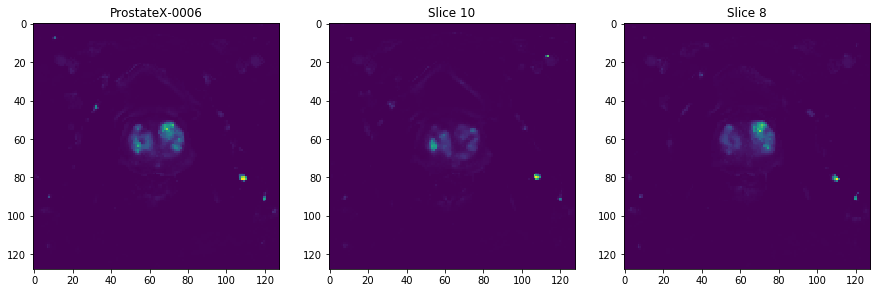

In [21]:
row = join_kimages_table[["ProxID","Kimg","Kimg3D" , "ClinSig","ijk"]].iloc[10]
print ("el estado es: {}".format(row.ClinSig))
plt.figure(figsize=(15,15))
plt.subplot(131),plt.imshow(row.Kimg),plt.title(row.ProxID)
plt.subplot(132),plt.imshow(row.Kimg3D[10]),plt.title("Slice 10")
plt.subplot(133),plt.imshow(row.Kimg3D[8]),plt.title("Slice 8")
print("El voxel corresponde a (ijk): {}".format(row.ijk))


the patient has cancer
El voxel corresponde a (ijk): 56 75 7


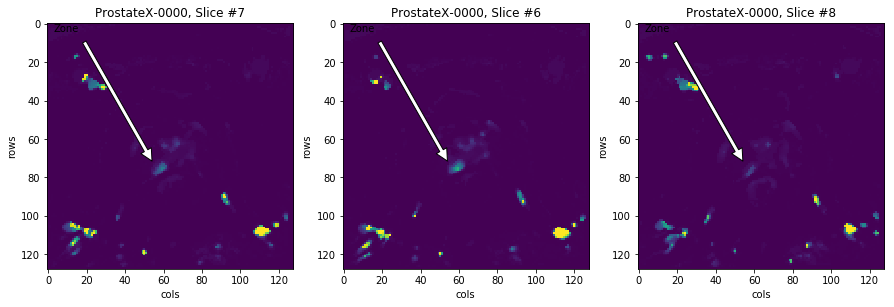

In [22]:
row = join_kimages_table[["ProxID","Kimg","Kimg3D" , "ClinSig","ijk"]].iloc[0]
ijk = row.ijk.split()
if row.ClinSig == True:
        ClinSig = "the patient has cancer"
else:
        ClinSig = "the patient has no cancer"
print(ClinSig)
fig2 = plt.figure(figsize=(15,15))
ax = fig2.add_subplot(131)
ax.set_xlabel('cols')
ax.set_ylabel('rows')
ax.imshow(row.Kimg3D[int(ijk[2])])
ax.annotate('Zone', xy=(int(ijk[0]), int(ijk[1])), xytext=(3, 4),
            arrowprops=dict(facecolor='white', shrink=0.05))
ax.set_title("{}, Slice #{}".format(row.ProxID,int(ijk[2])))

bx = fig2.add_subplot(132)
bx.set_xlabel('cols')
bx.set_ylabel('rows')
bx.imshow(row.Kimg3D[int(ijk[2])-1])
bx.annotate('Zone', xy=(int(ijk[0]), int(ijk[1])), xytext=(3, 4),
            arrowprops=dict(facecolor='white', shrink=0.05))
bx.set_title("{}, Slice #{}".format(row.ProxID,int(ijk[2])-1 ))

cx = fig2.add_subplot(133)
cx.set_xlabel('cols')
cx.set_ylabel('rows')
cx.imshow(row.Kimg3D[int(ijk[2])+1])
cx.annotate('Zone', xy=(int(ijk[0]), int(ijk[1])), xytext=(3, 4),
            arrowprops=dict(facecolor='white', shrink=0.05))
cx.set_title("{}, Slice #{}".format(row.ProxID,int(ijk[2])+ 1 ))
print("El voxel corresponde a (ijk): {}".format(row.ijk))


# Mostrando los datos de los patches 3D para entrenar el nuevo algoritmo.

In [24]:
indexes = np.random.randint(0,len(join_kimages_table),size=5)

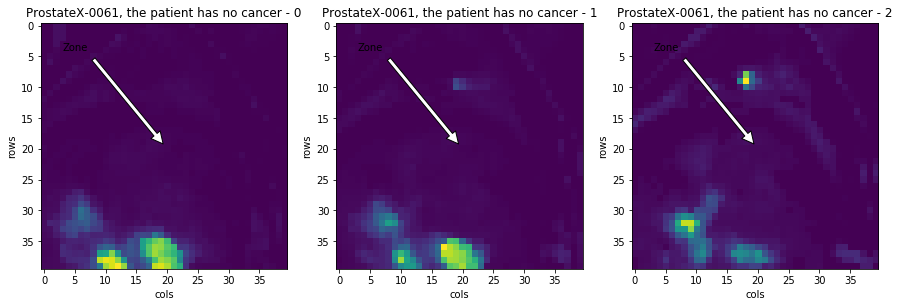

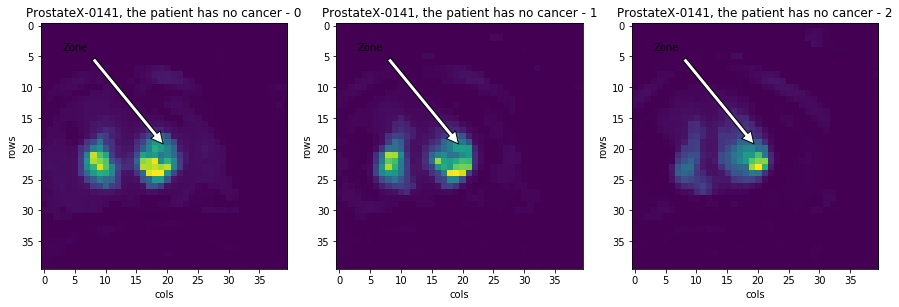

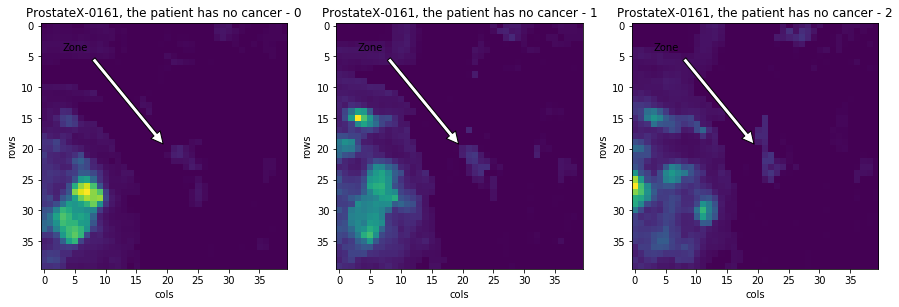

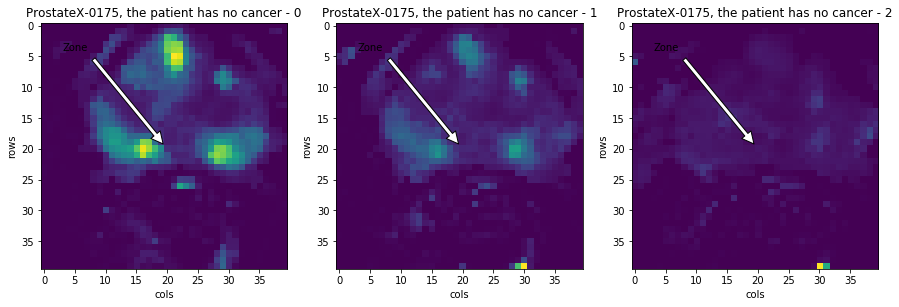

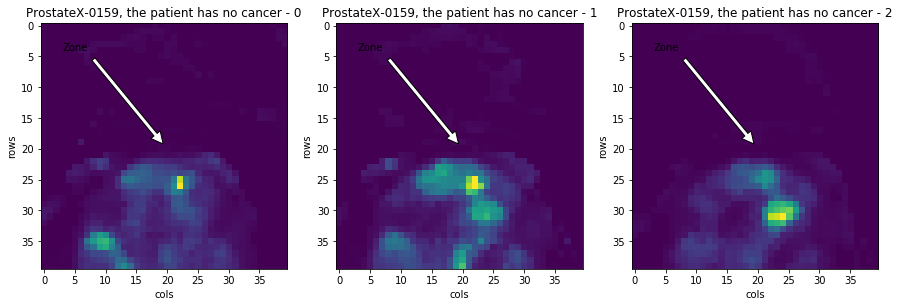

In [25]:
for index in indexes:
    row = join_kimages_table.iloc[index]
    ijk = row.ijk.split()
    if row.ClinSig == True:
        ClinSig = "the patient has cancer"
    else:
        ClinSig = "the patient has no cancer"
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(131)
    ax.set_xlabel('cols')
    ax.set_ylabel('rows')
    ax.imshow(row.KimgPatch3D[0])
    ax.annotate('Zone', xy=(row.KimgPatch3D.shape[1]/2,row.KimgPatch3D.shape[2]/2), xytext=(3, 4),
            arrowprops=dict(facecolor='white', shrink=0.05))
    ax.set_title('{}, {} - 0'.format(row.ProxID,ClinSig))
    bx = fig.add_subplot(132)
    bx.set_xlabel('cols')
    bx.set_ylabel('rows')
    bx.imshow(row.KimgPatch3D[1])
    bx.annotate('Zone', xy=(row.KimgPatch3D.shape[1]/2,row.KimgPatch3D.shape[2]/2), xytext=(3, 4),
            arrowprops=dict(facecolor='white', shrink=0.05))
    bx.set_title('{}, {} - 1'.format(row.ProxID,ClinSig))
    cx = fig.add_subplot(133)
    cx.set_xlabel('cols')
    cx.set_ylabel('rows')
    cx.imshow(row.KimgPatch3D[2])
    cx.annotate('Zone', xy=(row.KimgPatch3D.shape[1]/2,row.KimgPatch3D.shape[2]/2), xytext=(3, 4),
            arrowprops=dict(facecolor='white', shrink=0.05))
    cx.set_title('{}, {} - 2'.format(row.ProxID,ClinSig))

# Creamos patches de sub voxeles de (3,40,40)

In [26]:
def get_data_labels_Kimages(table):
    slices, rows, cols  = table.KimgPatch3D.iloc[0].shape
    data = np.ndarray(shape=(len(table), slices , rows, cols),
                             dtype=np.float32)
    labels = np.ndarray(shape=(len(table),1),
                             dtype=np.float32)
    for index in range (len(table)):
        slices, rows, cols =  table.KimgPatch3D.iloc[index].shape
        data[index, : , : , : ] = table.KimgPatch3D.iloc[index]
        labels[index] = table.ClinSig.iloc[index]
    print("The shape of the data is: {}".format(data.shape) )
    data  = data.reshape((len(table),slices*rows*cols))
    print("The shape of the data was reshaped to: {}".format(data.shape))
    labels = labels.reshape((len(table),))
    del table
    return data, labels

In [27]:
classifiers_table = pd.DataFrame(columns=["Classifier name","Prostate zone","Samples","Score", "TPR" , "P", "TNR", "N"])
zones = join_kimages_table[join_kimages_table["State"] == False].zone.unique()
for zone in zones:
    print("this is an experiment for the zone: {}".format(zone))
    training_table, testing_table = get_training_testing_tables(zone)
    print ("There is a total of {} patients with cancer at the training data".format(sum(training_table.ClinSig)))
    print ("There is a total of {} patients with cancer at the testing data".format(sum (testing_table.ClinSig)))
    training_data, training_labels = get_data_labels_Kimages(training_table)
    testing_data, testing_labels = get_data_labels_Kimages(testing_table)
    print("The data and the labels are ready for training and testing.") 
    print("=====================================================================================================")
    classifier1 = GaussianNB()
    classifier1.fit(training_data, training_labels)
    result = classifier1.score(testing_data,testing_labels)
    #Calculates the true positive rate and the true negative rate
    predicted_labels = classifier1.predict(testing_data)
    TPR, TNR , P , N = get_TPR_TNR(testing_labels, predicted_labels)
    print ("This was an experiment using GaussianNB classifier and only kimages of the {}.".format(zone)) 
    print("the number of samples in training were {} ".format(
    len(training_table)) + "and the number of samples in testing were {} ".format(len(testing_data)))
    print("the score of the accuracy in this experiment was {0:.5f}%".format(float(result)*100))
    print("This means that there was {}/{} correct predictions at testing.".format(int(result*len(testing_data)), len(testing_data) ))
    index = len(classifiers_table)
    classifiers_table.at[index,"Classifier name"] = "GaussianNB"
    classifiers_table.at[index,"Prostate zone"] = zone
    classifiers_table.at[index,"Score"] = result
    classifiers_table.at[index,"Samples"] = "{}/{}".format(int(result*len(testing_data)), len(testing_data) )
    classifiers_table.at[index,"TPR"] = TPR
    classifiers_table.at[index,"TNR"] = TNR
    classifiers_table.at[index,"P"] = P
    classifiers_table.at[index,"N"] = N
    print("=====================================================================================================")
    classifier2 = svm.SVC()
    classifier2.fit(training_data, training_labels)
    result = classifier2.score(testing_data,testing_labels)
    #Calculates the true positive rate and the true negative rate
    predicted_labels = classifier2.predict(testing_data)
    TPR, TNR , P , N = get_TPR_TNR(testing_labels, predicted_labels)
    print("=====================================================================================================")
    print ("This was an experiment using SVM-SVC classifier and only kimages of the {}.".format(zone)) 
    print("the number of samples in training were {} ".format(
    len(training_table)) + "and the number of samples in testing were {} ".format(len(testing_data)))
    print("the score of the accuracy in this experiment was {0:.5f}%".format(float(result)*100))
    print("This means that there was {}/{} correct predictions at testing.".format(int(result*len(testing_data)), len(testing_data) ))
    index = len(classifiers_table)
    classifiers_table.at[index,"Classifier name"] = "SVM-SVC"
    classifiers_table.at[index,"Prostate zone"] = zone
    classifiers_table.at[index,"Score"] = result
    classifiers_table.at[index,"Samples"] = "{}/{}".format(int(result*len(testing_data)), len(testing_data) )
    classifiers_table.at[index,"TPR"] = TPR
    classifiers_table.at[index,"TNR"] = TNR
    classifiers_table.at[index,"P"] = P
    classifiers_table.at[index,"N"] = N
    print("=====================================================================================================")
    print("=====================================================================================================")
    classifier3 = tree.DecisionTreeClassifier()
    classifier3.fit(training_data, training_labels)
    result = classifier3.score(testing_data,testing_labels)
    #Calculates the true positive rate and the true negative rate
    predicted_labels = classifier3.predict(testing_data)
    TPR, TNR , P , N = get_TPR_TNR(testing_labels, predicted_labels)
    print ("This was an experiment using Decision Tree classifier and only kimages of the {}.".format(zone)) 
    print("the number of samples in training were {} ".format(
    len(training_table)) + "and the number of samples in testing were {} ".format(len(testing_data)))
    print("the score of the accuracy in this experiment was {0:.5f}%".format(float(result)*100))
    print("This means that there was {}/{} correct predictions at testing.".format(int(result*len(testing_data)), len(testing_data) ))
    index = len(classifiers_table)
    classifiers_table.at[index,"Classifier name"] = "Decision Tree"
    classifiers_table.at[index,"Prostate zone"] = zone
    classifiers_table.at[index,"Score"] = result
    classifiers_table.at[index,"Samples"] = "{}/{}".format(int(result*len(testing_data)), len(testing_data) )
    classifiers_table.at[index,"TPR"] = TPR
    classifiers_table.at[index,"TNR"] = TNR
    classifiers_table.at[index,"P"] = P
    classifiers_table.at[index,"N"] = N
    print("=====================================================================================================")
    print("=====================================================================================================")
    n_estimators = 20
    classifier4 = RandomForestClassifier(n_estimators=n_estimators)
    classifier4.fit(training_data, training_labels)
    result = classifier4.score(testing_data,testing_labels)
    #Calculates the true positive rate and the true negative rate
    predicted_labels = classifier4.predict(testing_data)
    TPR, TNR , P , N = get_TPR_TNR(testing_labels, predicted_labels)
    print ("This was an experiment using Random Forest classifier and only kimages of the {}.".format(zone)) 
    print("the number of samples in training were {} ".format(
    len(training_table)) + "and the number of samples in testing were {} ".format(len(testing_data)))
    print("the score of the accuracy in this experiment was {0:.5f}%".format(float(result)*100))
    print("This means that there was {}/{} correct predictions at testing.".format(int(result*len(testing_data)), len(testing_data) ))
    index = len(classifiers_table)
    classifiers_table.at[index,"Classifier name"] = "Random Forest-{}".format(n_estimators)
    classifiers_table.at[index,"Prostate zone"] = zone
    classifiers_table.at[index,"Score"] = result
    classifiers_table.at[index,"Samples"] = "{}/{}".format(int(result*len(testing_data)), len(testing_data) )
    classifiers_table.at[index,"TPR"] = TPR
    classifiers_table.at[index,"TNR"] = TNR
    classifiers_table.at[index,"P"] = P
    classifiers_table.at[index,"N"] = N
    print("=====================================================================================================")
    print("=====================================================================================================")
    n_neighbors=20
    classifier5 = neighbors.KNeighborsClassifier(n_neighbors)
    classifier5.fit(training_data, training_labels)
    result = classifier5.score(testing_data,testing_labels)
    #Calculates the true positive rate and the true negative rate
    predicted_labels = classifier5.predict(testing_data)
    TPR, TNR , P , N = get_TPR_TNR(testing_labels, predicted_labels)
    print ("This was an experiment using KNeighbors classifier and only kimages of the {}.".format(zone)) 
    print("the number of samples in training were {} ".format(
    len(training_table)) + "and the number of samples in testing were {} ".format(len(testing_data)))
    print("the score of the accuracy in this experiment was {0:.5f}%".format(float(result)*100))
    print("This means that there was {}/{} correct predictions at testing.".format(int(result*len(testing_data)), len(testing_data) ))
    index = len(classifiers_table)
    classifiers_table.at[index,"Classifier name"] = "KNeighbors-{}".format(n_neighbors)
    classifiers_table.at[index,"Prostate zone"] = zone
    classifiers_table.at[index,"Score"] = result
    classifiers_table.at[index,"Samples"] = "{}/{}".format(int(result*len(testing_data)), len(testing_data) )
    classifiers_table.at[index,"TPR"] = TPR
    classifiers_table.at[index,"TNR"] = TNR
    classifiers_table.at[index,"P"] = P
    classifiers_table.at[index,"N"] = N
    print("=====================================================================================================")


this is an experiment for the zone: PZ
There is a total of 18 patients with cancer at the training data
There is a total of 18 patients with cancer at the testing data
The shape of the data is: (97, 3, 40, 40)
The shape of the data was reshaped to: (97, 4800)
The shape of the data is: (97, 3, 40, 40)
The shape of the data was reshaped to: (97, 4800)
The data and the labels are ready for training and testing.
This was an experiment using GaussianNB classifier and only kimages of the PZ.
the number of samples in training were 97 and the number of samples in testing were 97 
the score of the accuracy in this experiment was 53.60825%
This means that there was 52/97 correct predictions at testing.
This was an experiment using SVM-SVC classifier and only kimages of the PZ.
the number of samples in training were 97 and the number of samples in testing were 97 
the score of the accuracy in this experiment was 81.44330%
This means that there was 79/97 correct predictions at testing.
This was an

In [28]:
classifiers_table

,Classifier name,Prostate zone,Samples,Score,TPR,P,TNR,N
0,GaussianNB,PZ,52/97,0.536082,0.388889,18,0.56962,79
1,SVM-SVC,PZ,79/97,0.814433,0,18,1,79
2,Decision Tree,PZ,69/97,0.71134,0.222222,18,0.822785,79
3,Random Forest-20,PZ,74/97,0.762887,0.111111,18,0.911392,79
4,KNeighbors-20,PZ,79/97,0.814433,0,18,1,79
5,GaussianNB,AS,14/28,0.5,0.5,16,0.5,12
6,SVM-SVC,AS,17/28,0.607143,0.5625,16,0.666667,12
7,Decision Tree,AS,10/28,0.357143,0.5625,16,0.0833333,12
8,Random Forest-20,AS,19/28,0.678571,0.5625,16,0.833333,12
9,KNeighbors-20,AS,15/28,0.535714,0.9375,16,0,12


## Balanceamos las clases generando datos virtuales para training.

In [29]:
def generete_virtual_data(training_table):
    cancer_samples = sum(training_table.ClinSig)
    non_cancer_samples = len(training_table)-sum(training_table.ClinSig)
    print("================================================================================================")
    print("this is an experiment for the zone: {}".format(zone))
    print("The number of patient with cancer at training is: {}".format(cancer_samples))
    print("The number of patient with no cancer at training is {}".format(non_cancer_samples))
    if (min(cancer_samples,non_cancer_samples) == cancer_samples):
        #Hay que balancear las muestras que tienen cancer
        training_cancer_table = training_table[training_table["ClinSig"]==True]
        print("the cancer table has {} samples".format(len(training_cancer_table)))
        number_of_samples = non_cancer_samples - cancer_samples
        virtual_data = np.ndarray(shape=(number_of_samples, 3, 40, 40),dtype=np.float32)
        cancer_data, cancer_labels = get_data_labels_Kimages(training_cancer_table)
        cancer_mean = cancer_data.mean(axis=0)
        cancer_std = cancer_data.std(axis=0)
        for j in range (number_of_samples):
            virtualized_samples = []
            for i in range (len(cancer_mean)):
                normal_distribution = stats.norm(loc = cancer_mean[i], scale = cancer_std[i])
                sample = normal_distribution.rvs(1)
                virtualized_samples.append(sample)
            print("The virtual data #{} was genereted".format(j+1))
            virtual_samples = np.array(virtualized_samples)
            virtual_samples = virtual_samples.reshape((3,40,40))
            virtual_data[j] = virtual_samples
        virtual_labels = np.ones(virtual_data.shape[0] )
    else:
        #Hay que balancear las muestras que no tienen cancer
        non_training_cancer_table = training_table[training_table["ClinSig"]==False]
        print("The non-cancer table  {} samples".format(len(non_training_cancer_table)))
        number_of_samples = cancer_samples - non_cancer_samples
        virtual_data = np.ndarray(shape=(number_of_samples, 3, 40, 40),dtype=np.float32)
        non_cancer_data, non_cancer_labels = get_data_labels_Kimages(non_training_cancer_table)
        non_cancer_mean = non_cancer_data.mean(axis=0)
        non_cancer_std =  non_cancer_data.std(axis=0)
        for j in range (number_of_samples):
            virtualized_samples = []
            for i in range (len(non_cancer_mean)):
                normal_distribution = stats.norm(loc = non_cancer_mean[i], scale = non_cancer_std[i])
                sample = normal_distribution.rvs(1)
                virtualized_samples.append(sample)
            print("The virtual data #{} was genereted".format(j+1))
            virtual_samples = np.array(virtualized_samples)
            virtual_samples = virtual_samples.reshape((3,40,40))
            virtual_data[j] = virtual_samples
        virtual_labels = np.zeros(virtual_data.shape[0])
    virtual_data = virtual_data.reshape(number_of_samples, 3*40*40)
    
    return virtual_data , virtual_labels

In [30]:
classifiers_table = pd.DataFrame(columns=["Classifier name","Prostate zone","Samples","Score", "TPR" , "P", "TNR", "N"])
zones = join_kimages_table[join_kimages_table["State"] == False].zone.unique()
for zone in zones:
    print("this is an experiment for the zone: {}".format(zone))
    training_table, testing_table = get_training_testing_tables(zone)
    print ("There is a total of {} patients with cancer at the training data".format(sum(training_table.ClinSig)))
    print ("There is a total of {} patients with cancer at the testing data".format(sum (testing_table.ClinSig)))
    training_data, training_labels = get_data_labels_Kimages(training_table)
    virtual_data, virtual_labels = generete_virtual_data(training_table)
    training_labels = np.insert(training_labels, len(training_data),values=virtual_labels)
    training_data = np.vstack((training_data,virtual_data))
    testing_data, testing_labels = get_data_labels_Kimages(testing_table)
    print("The data and the labels are ready for training and testing.") 
    print("=====================================================================================================")
    classifier1 = GaussianNB()
    classifier1.fit(training_data, training_labels)
    result = classifier1.score(testing_data,testing_labels)
    #Calculates the true positive rate and the true negative rate
    predicted_labels = classifier1.predict(testing_data)
    TPR, TNR , P , N = get_TPR_TNR(testing_labels, predicted_labels)
    print ("This was an experiment using GaussianNB classifier and only kimages of the {}.".format(zone)) 
    print("the number of samples in training were {} ".format(
    len(training_table)) + "and the number of samples in testing were {} ".format(len(testing_data)))
    print("the score of the accuracy in this experiment was {0:.5f}%".format(float(result)*100))
    print("This means that there was {}/{} correct predictions at testing.".format(int(result*len(testing_data)), len(testing_data) ))
    index = len(classifiers_table)
    classifiers_table.at[index,"Classifier name"] = "GaussianNB"
    classifiers_table.at[index,"Prostate zone"] = zone
    classifiers_table.at[index,"Score"] = result
    classifiers_table.at[index,"Samples"] = "{}/{}".format(int(result*len(testing_data)), len(testing_data) )
    classifiers_table.at[index,"TPR"] = TPR
    classifiers_table.at[index,"TNR"] = TNR
    classifiers_table.at[index,"P"] = P
    classifiers_table.at[index,"N"] = N
    print("=====================================================================================================")
    classifier2 = svm.SVC()
    classifier2.fit(training_data, training_labels)
    result = classifier2.score(testing_data,testing_labels)
    #Calculates the true positive rate and the true negative rate
    predicted_labels = classifier2.predict(testing_data)
    TPR, TNR , P , N = get_TPR_TNR(testing_labels, predicted_labels)
    print("=====================================================================================================")
    print ("This was an experiment using SVM-SVC classifier and only kimages of the {}.".format(zone)) 
    print("the number of samples in training were {} ".format(
    len(training_table)) + "and the number of samples in testing were {} ".format(len(testing_data)))
    print("the score of the accuracy in this experiment was {0:.5f}%".format(float(result)*100))
    print("This means that there was {}/{} correct predictions at testing.".format(int(result*len(testing_data)), len(testing_data) ))
    index = len(classifiers_table)
    classifiers_table.at[index,"Classifier name"] = "SVM-SVC"
    classifiers_table.at[index,"Prostate zone"] = zone
    classifiers_table.at[index,"Score"] = result
    classifiers_table.at[index,"Samples"] = "{}/{}".format(int(result*len(testing_data)), len(testing_data) )
    classifiers_table.at[index,"TPR"] = TPR
    classifiers_table.at[index,"TNR"] = TNR
    classifiers_table.at[index,"P"] = P
    classifiers_table.at[index,"N"] = N
    print("=====================================================================================================")
    print("=====================================================================================================")
    classifier3 = tree.DecisionTreeClassifier()
    classifier3.fit(training_data, training_labels)
    result = classifier3.score(testing_data,testing_labels)
    #Calculates the true positive rate and the true negative rate
    predicted_labels = classifier3.predict(testing_data)
    TPR, TNR , P , N = get_TPR_TNR(testing_labels, predicted_labels)
    print ("This was an experiment using Decision Tree classifier and only kimages of the {}.".format(zone)) 
    print("the number of samples in training were {} ".format(
    len(training_table)) + "and the number of samples in testing were {} ".format(len(testing_data)))
    print("the score of the accuracy in this experiment was {0:.5f}%".format(float(result)*100))
    print("This means that there was {}/{} correct predictions at testing.".format(int(result*len(testing_data)), len(testing_data) ))
    index = len(classifiers_table)
    classifiers_table.at[index,"Classifier name"] = "Decision Tree"
    classifiers_table.at[index,"Prostate zone"] = zone
    classifiers_table.at[index,"Score"] = result
    classifiers_table.at[index,"Samples"] = "{}/{}".format(int(result*len(testing_data)), len(testing_data) )
    classifiers_table.at[index,"TPR"] = TPR
    classifiers_table.at[index,"TNR"] = TNR
    classifiers_table.at[index,"P"] = P
    classifiers_table.at[index,"N"] = N
    print("=====================================================================================================")
    print("=====================================================================================================")
    n_estimators = 20
    classifier4 = RandomForestClassifier(n_estimators=n_estimators)
    classifier4.fit(training_data, training_labels)
    result = classifier4.score(testing_data,testing_labels)
    #Calculates the true positive rate and the true negative rate
    predicted_labels = classifier4.predict(testing_data)
    TPR, TNR , P , N = get_TPR_TNR(testing_labels, predicted_labels)
    print ("This was an experiment using Random Forest classifier and only kimages of the {}.".format(zone)) 
    print("the number of samples in training were {} ".format(
    len(training_table)) + "and the number of samples in testing were {} ".format(len(testing_data)))
    print("the score of the accuracy in this experiment was {0:.5f}%".format(float(result)*100))
    print("This means that there was {}/{} correct predictions at testing.".format(int(result*len(testing_data)), len(testing_data) ))
    index = len(classifiers_table)
    classifiers_table.at[index,"Classifier name"] = "Random Forest-{}".format(n_estimators)
    classifiers_table.at[index,"Prostate zone"] = zone
    classifiers_table.at[index,"Score"] = result
    classifiers_table.at[index,"Samples"] = "{}/{}".format(int(result*len(testing_data)), len(testing_data) )
    classifiers_table.at[index,"TPR"] = TPR
    classifiers_table.at[index,"TNR"] = TNR
    classifiers_table.at[index,"P"] = P
    classifiers_table.at[index,"N"] = N
    print("=====================================================================================================")
    print("=====================================================================================================")
    n_neighbors=20
    classifier5 = neighbors.KNeighborsClassifier(n_neighbors)
    classifier5.fit(training_data, training_labels)
    result = classifier5.score(testing_data,testing_labels)
    #Calculates the true positive rate and the true negative rate
    predicted_labels = classifier5.predict(testing_data)
    TPR, TNR , P , N = get_TPR_TNR(testing_labels, predicted_labels)
    print ("This was an experiment using KNeighbors classifier and only kimages of the {}.".format(zone)) 
    print("the number of samples in training were {} ".format(
    len(training_table)) + "and the number of samples in testing were {} ".format(len(testing_data)))
    print("the score of the accuracy in this experiment was {0:.5f}%".format(float(result)*100))
    print("This means that there was {}/{} correct predictions at testing.".format(int(result*len(testing_data)), len(testing_data) ))
    index = len(classifiers_table)
    classifiers_table.at[index,"Classifier name"] = "KNeighbors-{}".format(n_neighbors)
    classifiers_table.at[index,"Prostate zone"] = zone
    classifiers_table.at[index,"Score"] = result
    classifiers_table.at[index,"Samples"] = "{}/{}".format(int(result*len(testing_data)), len(testing_data) )
    classifiers_table.at[index,"TPR"] = TPR
    classifiers_table.at[index,"TNR"] = TNR
    classifiers_table.at[index,"P"] = P
    classifiers_table.at[index,"N"] = N
    print("=====================================================================================================")
    


this is an experiment for the zone: PZ
There is a total of 18 patients with cancer at the training data
There is a total of 18 patients with cancer at the testing data
The shape of the data is: (97, 3, 40, 40)
The shape of the data was reshaped to: (97, 4800)
this is an experiment for the zone: PZ
The number of patient with cancer at training is: 18
The number of patient with no cancer at training is 79
the cancer table has 18 samples
The shape of the data is: (18, 3, 40, 40)
The shape of the data was reshaped to: (18, 4800)
The virtual data #1 was genereted
The virtual data #2 was genereted
The virtual data #3 was genereted
The virtual data #4 was genereted
The virtual data #5 was genereted
The virtual data #6 was genereted
The virtual data #7 was genereted
The virtual data #8 was genereted
The virtual data #9 was genereted
The virtual data #10 was genereted
The virtual data #11 was genereted
The virtual data #12 was genereted
The virtual data #13 was genereted
The virtual data #14 wa

The virtual data #2 was genereted
The virtual data #3 was genereted
The virtual data #4 was genereted
The virtual data #5 was genereted
The virtual data #6 was genereted
The virtual data #7 was genereted
The virtual data #8 was genereted
The virtual data #9 was genereted
The virtual data #10 was genereted
The virtual data #11 was genereted
The virtual data #12 was genereted
The virtual data #13 was genereted
The virtual data #14 was genereted
The virtual data #15 was genereted
The virtual data #16 was genereted
The virtual data #17 was genereted
The virtual data #18 was genereted
The virtual data #19 was genereted
The virtual data #20 was genereted
The virtual data #21 was genereted
The virtual data #22 was genereted
The virtual data #23 was genereted
The virtual data #24 was genereted
The virtual data #25 was genereted
The virtual data #26 was genereted
The virtual data #27 was genereted
The virtual data #28 was genereted
The virtual data #29 was genereted
The virtual data #30 was gen

In [31]:
classifiers_table

,Classifier name,Prostate zone,Samples,Score,TPR,P,TNR,N
0,GaussianNB,PZ,51/97,0.525773,0.333333,18,0.56962,79
1,SVM-SVC,PZ,64/97,0.659794,0.277778,18,0.746835,79
2,Decision Tree,PZ,68/97,0.701031,0.222222,18,0.810127,79
3,Random Forest-20,PZ,80/97,0.824742,0.166667,18,0.974684,79
4,KNeighbors-20,PZ,79/97,0.814433,0,18,1,79
5,GaussianNB,AS,14/28,0.5,0.5625,16,0.416667,12
6,SVM-SVC,AS,16/28,0.571429,0.375,16,0.833333,12
7,Decision Tree,AS,14/28,0.5,0.375,16,0.666667,12
8,Random Forest-20,AS,16/28,0.571429,0.5,16,0.666667,12
9,KNeighbors-20,AS,14/28,0.5,0.25,16,0.833333,12


# Hacemos un plot de un ejemplo de los datos virtuales generados.

The patient has cancer.
The patient has no cancer.


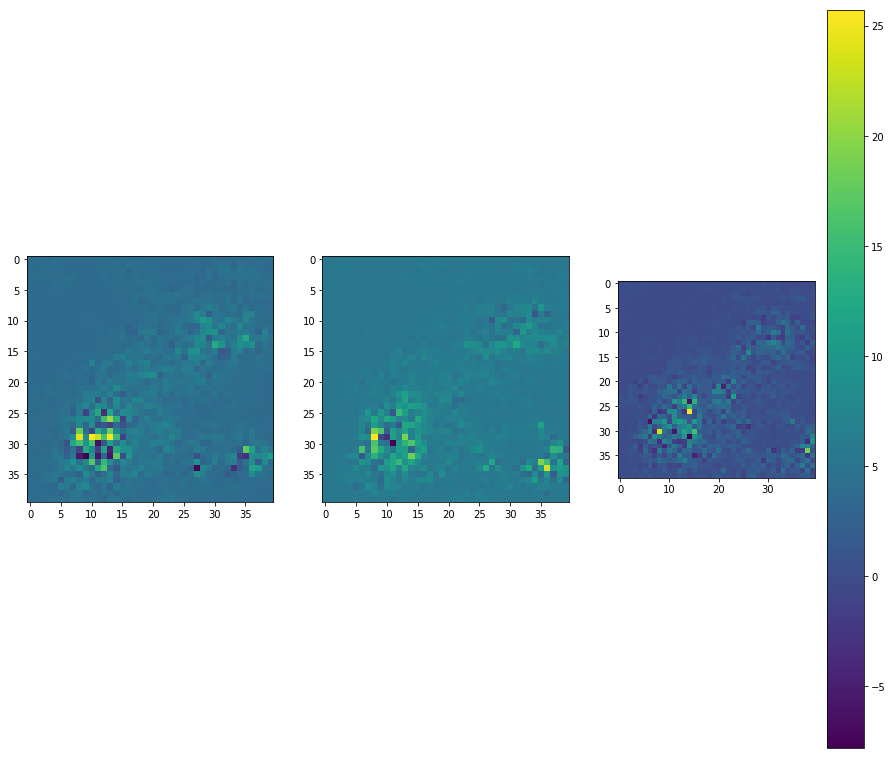

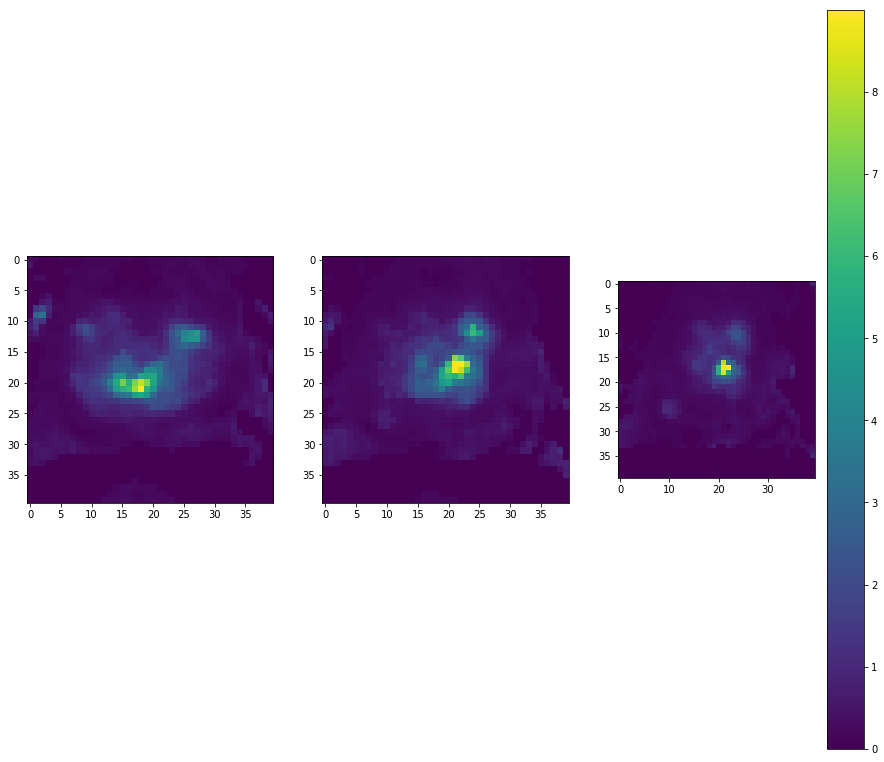

In [46]:
virtual_data_example = virtual_data[17].reshape((3,40,40))
plt.figure(figsize=(15,15))
plt.subplot(131) , plt.imshow(virtual_data_example[0,:,:])
plt.subplot(132) , plt.imshow(virtual_data_example[1,:,:])
plt.subplot(133) , plt.imshow(virtual_data_example[2,:,:])
plt.colorbar()
if virtual_labels[17] == 1:
    print ("The patient has cancer.")
else:
    print ("The patient has no cancer.")
    
training_data_example = training_data[1].reshape((3,40,40))
plt.figure(figsize=(15,15))
plt.subplot(131) , plt.imshow(training_data_example[0,:,:])
plt.subplot(132) , plt.imshow(training_data_example[1,:,:])
plt.subplot(133) , plt.imshow(training_data_example[2,:,:])
if training_labels[1] == 1:
    print ("The patient has cancer.")
else:
    print ("The patient has no cancer.")
plt.colorbar()

## Balanceamos las clases generando datos virtuales para training y para testing.

In [33]:
classifiers_table = pd.DataFrame(columns=["Classifier name","Prostate zone","Samples","Score", "TPR" , "P", "TNR", "N"])
zones = join_kimages_table[join_kimages_table["State"] == False].zone.unique()
for zone in zones:
    print("this is an experiment for the zone: {}".format(zone))
    training_table, testing_table = get_training_testing_tables(zone)
    print ("There is a total of {} patients with cancer at the training data".format(sum(training_table.ClinSig)))
    print ("There is a total of {} patients with cancer at the testing data".format(sum (testing_table.ClinSig)))
    training_data, training_labels = get_data_labels_Kimages(training_table)
    virtual_data, virtual_labels = generete_virtual_data(training_table)
    training_labels = np.insert(training_labels, len(training_data),values=virtual_labels)
    training_data = np.vstack((training_data,virtual_data))
    virtual_data_testing, virtual_labels_testing = generete_virtual_data(testing_table)
    testing_data, testing_labels = get_data_labels_Kimages(testing_table)
    testing_labels = np.insert(testing_labels, len(testing_data) , values= virtual_labels_testing)
    testing_data = np.vstack((testing_data,virtual_data_testing))
    print("The data and the labels are ready for training and testing.") 
    print("=====================================================================================================")
    classifier1 = GaussianNB()
    classifier1.fit(training_data, training_labels)
    result = classifier1.score(testing_data,testing_labels)
    #Calculates the true positive rate and the true negative rate
    predicted_labels = classifier1.predict(testing_data)
    TPR, TNR , P , N = get_TPR_TNR(testing_labels, predicted_labels)
    print ("This was an experiment using GaussianNB classifier and only kimages of the {}.".format(zone)) 
    print("the number of samples in training were {} ".format(
    len(training_table)) + "and the number of samples in testing were {} ".format(len(testing_data)))
    print("the score of the accuracy in this experiment was {0:.5f}%".format(float(result)*100))
    print("This means that there was {}/{} correct predictions at testing.".format(int(result*len(testing_data)), len(testing_data) ))
    index = len(classifiers_table)
    classifiers_table.at[index,"Classifier name"] = "GaussianNB"
    classifiers_table.at[index,"Prostate zone"] = zone
    classifiers_table.at[index,"Score"] = result
    classifiers_table.at[index,"Samples"] = "{}/{}".format(int(result*len(testing_data)), len(testing_data) )
    classifiers_table.at[index,"TPR"] = TPR
    classifiers_table.at[index,"TNR"] = TNR
    classifiers_table.at[index,"P"] = P
    classifiers_table.at[index,"N"] = N
    print("=====================================================================================================")
    classifier2 = svm.SVC()
    classifier2.fit(training_data, training_labels)
    result = classifier2.score(testing_data,testing_labels)
    #Calculates the true positive rate and the true negative rate
    predicted_labels = classifier2.predict(testing_data)
    TPR, TNR , P , N = get_TPR_TNR(testing_labels, predicted_labels)
    print("=====================================================================================================")
    print ("This was an experiment using SVM-SVC classifier and only kimages of the {}.".format(zone)) 
    print("the number of samples in training were {} ".format(
    len(training_table)) + "and the number of samples in testing were {} ".format(len(testing_data)))
    print("the score of the accuracy in this experiment was {0:.5f}%".format(float(result)*100))
    print("This means that there was {}/{} correct predictions at testing.".format(int(result*len(testing_data)), len(testing_data) ))
    index = len(classifiers_table)
    classifiers_table.at[index,"Classifier name"] = "SVM-SVC"
    classifiers_table.at[index,"Prostate zone"] = zone
    classifiers_table.at[index,"Score"] = result
    classifiers_table.at[index,"Samples"] = "{}/{}".format(int(result*len(testing_data)), len(testing_data) )
    classifiers_table.at[index,"TPR"] = TPR
    classifiers_table.at[index,"TNR"] = TNR
    classifiers_table.at[index,"P"] = P
    classifiers_table.at[index,"N"] = N
    print("=====================================================================================================")
    print("=====================================================================================================")
    classifier3 = tree.DecisionTreeClassifier()
    classifier3.fit(training_data, training_labels)
    result = classifier3.score(testing_data,testing_labels)
    #Calculates the true positive rate and the true negative rate
    predicted_labels = classifier3.predict(testing_data)
    TPR, TNR , P , N = get_TPR_TNR(testing_labels, predicted_labels)
    print ("This was an experiment using Decision Tree classifier and only kimages of the {}.".format(zone)) 
    print("the number of samples in training were {} ".format(
    len(training_table)) + "and the number of samples in testing were {} ".format(len(testing_data)))
    print("the score of the accuracy in this experiment was {0:.5f}%".format(float(result)*100))
    print("This means that there was {}/{} correct predictions at testing.".format(int(result*len(testing_data)), len(testing_data) ))
    index = len(classifiers_table)
    classifiers_table.at[index,"Classifier name"] = "Decision Tree"
    classifiers_table.at[index,"Prostate zone"] = zone
    classifiers_table.at[index,"Score"] = result
    classifiers_table.at[index,"Samples"] = "{}/{}".format(int(result*len(testing_data)), len(testing_data) )
    classifiers_table.at[index,"TPR"] = TPR
    classifiers_table.at[index,"TNR"] = TNR
    classifiers_table.at[index,"P"] = P
    classifiers_table.at[index,"N"] = N
    print("=====================================================================================================")
    print("=====================================================================================================")
    n_estimators = 20
    classifier4 = RandomForestClassifier(n_estimators=n_estimators)
    classifier4.fit(training_data, training_labels)
    result = classifier4.score(testing_data,testing_labels)
    #Calculates the true positive rate and the true negative rate
    predicted_labels = classifier4.predict(testing_data)
    TPR, TNR , P , N = get_TPR_TNR(testing_labels, predicted_labels)
    print ("This was an experiment using Random Forest classifier and only kimages of the {}.".format(zone)) 
    print("the number of samples in training were {} ".format(
    len(training_table)) + "and the number of samples in testing were {} ".format(len(testing_data)))
    print("the score of the accuracy in this experiment was {0:.5f}%".format(float(result)*100))
    print("This means that there was {}/{} correct predictions at testing.".format(int(result*len(testing_data)), len(testing_data) ))
    index = len(classifiers_table)
    classifiers_table.at[index,"Classifier name"] = "Random Forest-{}".format(n_estimators)
    classifiers_table.at[index,"Prostate zone"] = zone
    classifiers_table.at[index,"Score"] = result
    classifiers_table.at[index,"Samples"] = "{}/{}".format(int(result*len(testing_data)), len(testing_data) )
    classifiers_table.at[index,"TPR"] = TPR
    classifiers_table.at[index,"TNR"] = TNR
    classifiers_table.at[index,"P"] = P
    classifiers_table.at[index,"N"] = N
    print("=====================================================================================================")
    print("=====================================================================================================")
    n_neighbors=20
    classifier5 = neighbors.KNeighborsClassifier(n_neighbors)
    classifier5.fit(training_data, training_labels)
    result = classifier5.score(testing_data,testing_labels)
    #Calculates the true positive rate and the true negative rate
    predicted_labels = classifier5.predict(testing_data)
    TPR, TNR , P , N = get_TPR_TNR(testing_labels, predicted_labels)
    print ("This was an experiment using KNeighbors classifier and only kimages of the {}.".format(zone)) 
    print("the number of samples in training were {} ".format(
    len(training_table)) + "and the number of samples in testing were {} ".format(len(testing_data)))
    print("the score of the accuracy in this experiment was {0:.5f}%".format(float(result)*100))
    print("This means that there was {}/{} correct predictions at testing.".format(int(result*len(testing_data)), len(testing_data) ))
    index = len(classifiers_table)
    classifiers_table.at[index,"Classifier name"] = "KNeighbors-{}".format(n_neighbors)
    classifiers_table.at[index,"Prostate zone"] = zone
    classifiers_table.at[index,"Score"] = result
    classifiers_table.at[index,"Samples"] = "{}/{}".format(int(result*len(testing_data)), len(testing_data) )
    classifiers_table.at[index,"TPR"] = TPR
    classifiers_table.at[index,"TNR"] = TNR
    classifiers_table.at[index,"P"] = P
    classifiers_table.at[index,"N"] = N
    print("=====================================================================================================")
    


this is an experiment for the zone: PZ
There is a total of 18 patients with cancer at the training data
There is a total of 18 patients with cancer at the testing data
The shape of the data is: (97, 3, 40, 40)
The shape of the data was reshaped to: (97, 4800)
this is an experiment for the zone: PZ
The number of patient with cancer at training is: 18
The number of patient with no cancer at training is 79
the cancer table has 18 samples
The shape of the data is: (18, 3, 40, 40)
The shape of the data was reshaped to: (18, 4800)
The virtual data #1 was genereted
The virtual data #2 was genereted
The virtual data #3 was genereted
The virtual data #4 was genereted
The virtual data #5 was genereted
The virtual data #6 was genereted
The virtual data #7 was genereted
The virtual data #8 was genereted
The virtual data #9 was genereted
The virtual data #10 was genereted
The virtual data #11 was genereted
The virtual data #12 was genereted
The virtual data #13 was genereted
The virtual data #14 wa

The virtual data #1 was genereted
The virtual data #2 was genereted
The virtual data #3 was genereted
this is an experiment for the zone: AS
The number of patient with cancer at training is: 16
The number of patient with no cancer at training is 12
The non-cancer table  12 samples
The shape of the data is: (12, 3, 40, 40)
The shape of the data was reshaped to: (12, 4800)
The virtual data #1 was genereted
The virtual data #2 was genereted
The virtual data #3 was genereted
The virtual data #4 was genereted
The shape of the data is: (28, 3, 40, 40)
The shape of the data was reshaped to: (28, 4800)
The data and the labels are ready for training and testing.
This was an experiment using GaussianNB classifier and only kimages of the AS.
the number of samples in training were 27 and the number of samples in testing were 32 
the score of the accuracy in this experiment was 43.75000%
This means that there was 14/32 correct predictions at testing.
This was an experiment using SVM-SVC classifier 

This was an experiment using KNeighbors classifier and only kimages of the TZ.
the number of samples in training were 41 and the number of samples in testing were 74 
the score of the accuracy in this experiment was 51.35135%
This means that there was 38/74 correct predictions at testing.


In [34]:
classifiers_table

,Classifier name,Prostate zone,Samples,Score,TPR,P,TNR,N
0,GaussianNB,PZ,51/158,0.322785,0.0759494,79,0.56962,79
1,SVM-SVC,PZ,70/158,0.443038,0.151899,79,0.734177,79
2,Decision Tree,PZ,87/158,0.550633,0.35443,79,0.746835,79
3,Random Forest-20,PZ,106/158,0.670886,0.392405,79,0.949367,79
4,KNeighbors-20,PZ,79/158,0.5,0,79,1,79
5,GaussianNB,AS,14/32,0.4375,0.5,16,0.375,16
6,SVM-SVC,AS,20/32,0.625,0.375,16,0.875,16
7,Decision Tree,AS,18/32,0.5625,0.625,16,0.5,16
8,Random Forest-20,AS,17/32,0.53125,0.4375,16,0.625,16
9,KNeighbors-20,AS,18/32,0.5625,0.25,16,0.875,16
